참고한 kaggle 커널 주소 ::: <br>
https://www.kaggle.com/ateplyuk/pytorch-starter-u-net-resnet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms
import torch.nn.functional as F

## Read train dataframe

In [4]:
path = 'data/'

train.csv - 이미지 상 결함이 있는 곳을 표시해두었다.

In [5]:
tr = pd.read_csv(path + 'train.csv')
print(len(tr))
tr.head()

50272


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


<span style="color:red"><b>[중요!]</b></span> <b>프로세스를 빠르고 간소화하기 위해서 ClassId = 4인 이미지 파일만을 사용하기로 한다.</b>

In [8]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
df_train = df_train[df_train['ImageId_ClassId'].apply(lambda x: x.split('_')[1] == '4')].reset_index(drop=True)
print(len(df_train))
df_train.head()

801


,ImageId_ClassId,EncodedPixels
0,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
1,0025bde0c.jpg_4,315139 8 315395 15 315651 16 315906 17 316162 ...
2,002af848d.jpg_4,290800 6 291055 13 291311 15 291566 18 291822 ...
3,0030401a5.jpg_4,186833 1 187089 3 187344 6 187600 7 187855 10 ...
4,008621629.jpg_4,215548 3 215798 9 216051 12 216306 13 216560 1...


## Decode Mask
<b>런-렝스 부호화(Run-length encoding, RLE)</b> <br>
데이터에서 같은 값이 연속해서 나타나는 것을 그 개수와 반복되는 값만으로 표현하는 방법이다.<br>
만화나 애니메이션 등과 같이 배경의 변화가 없는 영상에 적합한 방식이다.<br>
<br>
예를 들어,<br>
흰 바탕에 검은 글자가 나오는 스크린을 생각하면 이 스크린에는 연속된 흰 픽셀이 많이 나타날 것이다. <br>
이러한 스크린의 한 스캔 라인이 다음과 같다고 가정하자. (흰 픽셀을 W로 표시하고 검은 픽셀을 B로 표시한다.)<br><br>

<b>WWWWWWWWWWWWBWWWWWWWWWWWWBBBWWWWWWWWWWWWWWWWWWWWWWWWBWWWWWWWWWWWWWW</b><br><br>
위의 데이터를 간단한 반복 길이 부호를 사용해서 압축하면 다음과 같은 결과를 얻을 수 있다.<br><br>

<b><span style='color:blue'>12W</span>B<span style='color:blue'>12W</span>3B<span style='color:blue'>24W</span>B<span style='color:blue'>14W</span></b><br><br>
이는 '12개의 W, (한 개의) B, 12개의 W, 3개의 B, 24개의 W, (한 개의) B, 14개의 W'로 해석한다.<br>
위의 예제의 경우, 압축 전에는 67글자였으나 압축 후에는 단지 16글자만으로 표현할 수 있다. <br>
물론 실제로 이러한 이미지는 바이너리 포맷으로 저장되며 반복되는 길이를 저장하는 방법도 다양하지만, <br>
기본적인 개념은 동일하다. 이때 <b><span style='color:red'>데이터의 크기는 67바이트에서 16바이트로 줄었으므로 압축률은 약 4.18</span></b>이다.
<br>
<br>
출처 ::: https://ko.wikipedia.org/wiki/%EB%9F%B0_%EB%A0%9D%EC%8A%A4_%EB%B6%80%ED%98%B8%ED%99%94

In [12]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask = np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    # EncodedPixel 데이터에서 결함이 있는 곳의 픽셀이 width height width height 순으로 나열되어있다.
    starts = array[0::2] # 따라서 두 칸씩 건너 뛰어야 한다!
    lengths = array[1::2] # 따라서 두 칸씩 건너 뛰어야 한다!
    
    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
    return np.flipud( np.rot90( mask.reshape(height, width), k=1))

* 참고

numpy.rot90() ::: Rotate an array by 90 degrees in the plane specified by axes. 행렬을 반시계방향으로 k번 회전한다. <br>
numpy.flipud() ::: Flip array in the up/down direction. 행렬을 위/아래로 뒤집는다.<br>
numpy.fliplr() ::: Flip an array horizontally. 행렬을 좌/우로 뒤집는다.

<b>이미지 파일과 결함 데이터를 보도록 한다.</b>

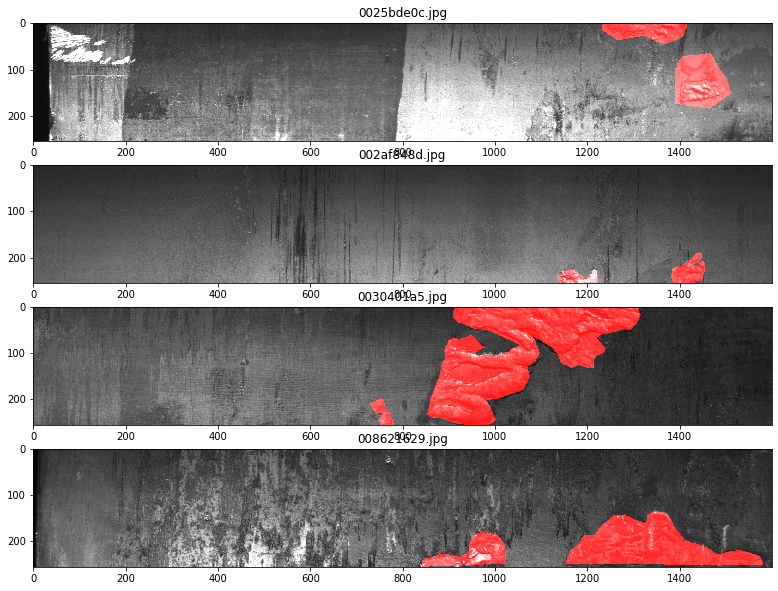

In [13]:
columns = 1
rows = 4
fig = plt.figure(figsize = (20, columns*rows+6))
for i in range(1, columns*rows+1):
    fn = df_train['ImageId_ClassId'].str[:-2].iloc[i]
    fig.add_subplot(rows, columns, i).set_title(fn)
    img = cv2.imread( path + 'train_images/'+fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(df_train['EncodedPixels'].iloc[i], (256, 1600))
    img[mask==1, 0] = 255
    plt.imshow(img)
plt.show()

* 참고

파이썬에서 OpenCV를 사용해서 사진을 matplotlib 으로 화면에 출력하는 방법입니다. <br><b>컬러 사진을 OpenCV에서는 BGR 순서로 저장하는데 matplotlib에서는 RGB 순서로 저장합니다.</b><br> 따라서 BGR을 RGB로 바꾸어 주어야만 사진이 제대로 표시됩니다.<br><br>

그림BGR = cv2.imread('그림파일.jpg')<br>
그림RGB = cv2.cvtColor(그림BGR, cv2.COLOR_BGR2RGB)<br>


출처 ::: https://crmn.tistory.com/49

## Create train Dataset and DataLoader

<br>

<b>Custom DataLoader</b>
<br><br>
우리가 직접 만드는 custom dataloader은 다음과 같은 세 파트로 이루어져 있습니다.
<br><br>
<span style='color:blue'>\_\_init\_\_(self)</span> ::: download, read data 등등을 하는 파트. <br>
<span style='color:blue'>\_\_getitem\_\_(self,index)</span> ::: 인덱스에 해당하는 아이템을 넘겨주는 파트.<br>
<span style='color:blue'>\_\_len\_\_(self)</span> ::: data size를 넘겨주는 파트<br><br>

출처 ::: https://wingnim.tistory.com/33

In [15]:
class ImageData(Dataset):
    def __init__(self, df, transform, subset="train"):
        super().__init__()
        self.df = df
        self.transform = transform
        self.subset = subset
        
        # subset 인자를 통해서 train 혹은 test 데이터를 가져올지 정한다.
        if self.subset == "train":
            self.data_path = path + 'train_images/'
        elif self.subset == "test":
            self.data_path = path + 'test_images/'
            
    # data size를 구한다.
    def __len__(self):
        return len(self.df)
    
    # 
    def __getitem__(self, index):                      
        fn = self.df['ImageId_ClassId'].iloc[index].split('_')[0]         
        img = Image.open(self.data_path + fn)
        img = self.transform(img)

        if self.subset == 'train': 
            mask = rle2mask(self.df['EncodedPixels'].iloc[index], (256, 1600))
            mask = transforms.ToPILImage()(mask)            
            mask = self.transform(mask)
            return img, mask
        else: 
            mask = None
            return img     

* 참고

torchvision.transforms.ToPILImage(mode=None) ::: Convert a tensor or an ndarray to PIL Image

In [16]:
data_transf = transforms.Compose([
    transforms.Scale((256,256)),
    transforms.ToTensor()])
train_data = ImageData(df = df_train, transform = data_transf)
train_loader = DataLoader(dataset = train_data, batch_size=4)

C:\Users\aa\Anaconda3\envs\dmqa_pytorch\lib\site-packages\torchvision\transforms\transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


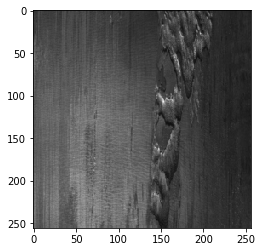

In [18]:
plt.imshow(train_data[3][0].permute(1, 2, 0))

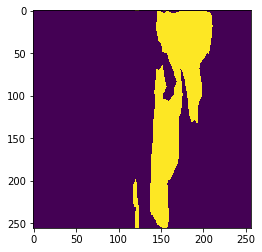

In [17]:
plt.imshow(np.squeeze(train_data[3][1].permute(1, 2, 0)))

* 참고

numpy.squeeze() ::: 차원을 축소한다.<br>
torch.tensor.permute() ::: only used to swap the axes

## Create U-Net Model

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18()
        self.base_model.load_state_dict(torch.load("../input/resnet18/resnet18.pth"))
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out